# Machine Learning Assignment 2


**COSC2673/COSC2793 Semester 1 2023**

**Machine Learning & Computational Machine Learning**
## Jonathon Mitterbacher (s3784464) & Elissa Van (s3935201)


# 1. Introduction
Using neural networks (NN) to build a supervised machine learning model/algorithm capable of classifing and predicting a human's cell's type (out of four; epithelial, inflammatory, fibroblast, miscellaneous/others) and whether or not a certain cell type is cancerous or not.

In [1]:
# Import the Required Libraries
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

2023-05-16 20:08:08.975570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Data Collection
## 2.1 Reading in Image Classification Data
Firstly, we need to extract and read in the `Image_classification_data` images from the provided Zip file.

In [2]:
import zipfile

# Extract 'Image_classification_data.zip' into the 'data' directory
with zipfile.ZipFile('./data/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

In [3]:
# Different image paths are required based on OS
#IMAGES_PATH = "./data/patch_images\\" # Use for Windows
IMAGES_PATH = "./data/patch_images/" # Use for Mac

image_list = []
for file_path in glob.glob('./data/patch_images/****.png', recursive=True):
    image_name = file_path.split(IMAGES_PATH)[-1]
    image_list.append((file_path, image_name))
    
# Create the image dataframe with 
image_data = pd.DataFrame(data=image_list, columns=['ImagePath', 'ImageName'])

In [4]:
image_data

,ImagePath,ImageName
0,./data/patch_images/3975.png,3975.png
1,./data/patch_images/17843.png,17843.png
2,./data/patch_images/21329.png,21329.png
3,./data/patch_images/8820.png,8820.png
4,./data/patch_images/14392.png,14392.png
...,...,...
20275,./data/patch_images/15095.png,15095.png
20276,./data/patch_images/6814.png,6814.png
20277,./data/patch_images/21330.png,21330.png
20278,./data/patch_images/17682.png,17682.png


### 2.1.1 Display Image Data
Displaying the extracted images to verify that they look as we would expect.

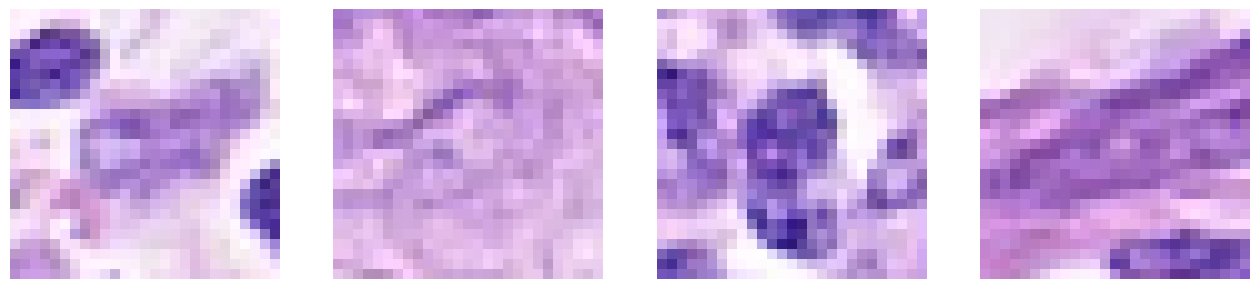

In [5]:
r_inx = np.random.choice(100, 4)
rand_data = image_data.loc[r_inx,'ImagePath']

plt.figure(figsize=(16,4))
for i, imagePath in enumerate(rand_data):
    im = np.asarray(Image.open(imagePath))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

## 2.2 Reading in Main Data
Using pandas to read in dataframe, `data_labels_mainData.csv` from csv files to extract data for image classification.

In [6]:
main_data = pd.read_csv('./data/data_labels_mainData.csv')
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


## 2.3 Reading in Extra Data
Using pandas to read in data set, `data_labels_extraData.csv` from csv files to extract data for image classification.

In [7]:
# to use xtra data for predicting cell type, we can perform eda to identify any existing trends (all epithelial cells are cancerous)
extra_data = pd.read_csv('data/data_labels_extraData.csv')
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


# 3. Data Pre-Processing

## 3.1 Check for Missing Values

### 3.1.1 Image Data
Look for any columns with a lower `Non-Null Count` than the neighbouring columns.

In [8]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImagePath  20280 non-null  object
 1   ImageName  20280 non-null  object
dtypes: object(2)
memory usage: 317.0+ KB


Given that both the **ImagePath** and **ImageName** columns contain 20280 non-null values, we can assume that there are **no missing values**.

### 3.1.2 Main Data
Checking the `main_data` dataset's column names, their corresponding data types and whether they contain null values or not with `info()` function.

In [9]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


Given that the six `main_data` columns (InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous) each contain 9896 non-null values, we can assume that there are **no missing values in main_data**.

### 3.1.3 Extra Data
Checking the `extra_data` dataset's column names, their corresponding data types and whether they contain null values or not with `info()` function.

In [10]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


Given that the four `extra_data` columns (InstanceID, patientID, ImageName, isCancerous) each contain 10384 non-null values, we can assume that there are **no missing values in extra_data**.

## 3.2 Check for NaN Values
Identify any NaN (Not a Number) values to ensure that all our data entries are valid using `.isna()` and `.sum()`.

In [11]:
image_data.isna().sum()

ImagePath    0
ImageName    0
dtype: int64

We can see that our `image_data` dataset has **no NaN values**.

### 3.2.1 Main Data

In [12]:
main_data.isna().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

We can see that our `main_data` dataset has **no NaN values**.

### 3.2.2 Extra Data

In [13]:
extra_data.isna().sum()

InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

We can see that our `extra_data` dataset has **no NaN values**.

## 3.3 Check for Empty Strings
### 3.3.1 Image Data
Check for empty strings in columns with the `object` (string) data type in `image_data`: **ImageName**, & **ImagePath**.

If our image pathes contain empty strings, our model will not be able to correctly read them in.

Thus we need to look for and remove any of these invalid entries.

In [14]:
def PrintEmptyStringsInColumn(dataframe, column):
    # Check for empty strings in the 'ImagePath' and 'ImageName' columns
    empty_string_data = (dataframe[column] == '') | (dataframe[column].str.strip() == '')

    # Print the number of empty strings found in image_data
    print("Empty Strings in {column}: {NumEmptyStrings} ".format(column = column, NumEmptyStrings = len(dataframe.loc[empty_string_data])))
    
PrintEmptyStringsInColumn(image_data, 'ImagePath')
PrintEmptyStringsInColumn(image_data, 'ImageName')

Empty Strings in ImagePath: 0 
Empty Strings in ImageName: 0 


There are no empty strings and thus all values in **ImagePath** and **ImageName** are populated.

### 3.3.2 Main Data
Check for empty strings in columns with the `object` (string) data type in `main_data`: **cellTypeName** and **ImageName**.

In [15]:
PrintEmptyStringsInColumn(main_data, 'cellTypeName')
PrintEmptyStringsInColumn(main_data, 'ImageName')

Empty Strings in cellTypeName: 0 
Empty Strings in ImageName: 0 


### 3.3.3 Extra Data
Check for empty strings in columns with the `object` (string) data type in `extra_data`: **ImageName**.

In [16]:
PrintEmptyStringsInColumn(extra_data, 'ImageName')

Empty Strings in ImageName: 0 


# 4. Exploratory Data Analysis (EDA)

## 4.1 Adding Label Columns
A `isCancerous` value of **0** represents a **Not Cancerous** cell, whereas a value of **1** represents a **Cancerous** cell.

### 4.1.1 isCancerousName
Create an `isCancerousName` label column to both the datasets based on their values in the `isCancerous` column.

In [17]:
isCancerous_labels = {0:'Not Cancerous', 1:'Cancerous'}

# Add the new column, 'isCancerousName' to the main data set 
main_data['isCancerousName'] = main_data['isCancerous'].map(isCancerous_labels, na_action='ignore')
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,isCancerousName
0,22405,1,22405.png,fibroblast,0,0,Not Cancerous
1,22406,1,22406.png,fibroblast,0,0,Not Cancerous
2,22407,1,22407.png,fibroblast,0,0,Not Cancerous
3,22408,1,22408.png,fibroblast,0,0,Not Cancerous
4,22409,1,22409.png,fibroblast,0,0,Not Cancerous
...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,Cancerous
9892,1626,60,1626.png,epithelial,2,1,Cancerous
9893,1627,60,1627.png,epithelial,2,1,Cancerous
9894,1628,60,1628.png,epithelial,2,1,Cancerous


In [18]:
# Add the new column, 'isCancerousName' to the extra data set 
extra_data['isCancerousName'] = extra_data['isCancerous'].map(isCancerous_labels, na_action='ignore')
extra_data

,InstanceID,patientID,ImageName,isCancerous,isCancerousName
0,12681,61,12681.png,0,Not Cancerous
1,12682,61,12682.png,0,Not Cancerous
2,12683,61,12683.png,0,Not Cancerous
3,12684,61,12684.png,0,Not Cancerous
4,12685,61,12685.png,0,Not Cancerous
...,...,...,...,...,...
10379,20028,99,20028.png,0,Not Cancerous
10380,20029,99,20029.png,0,Not Cancerous
10381,20030,99,20030.png,0,Not Cancerous
10382,20031,99,20031.png,0,Not Cancerous


## 4.2 Main Data

### 4.2.1 CellType Exploration ### 
Looking at label distribution, `cellTypeName` (and `cellType`) from `main_data`.

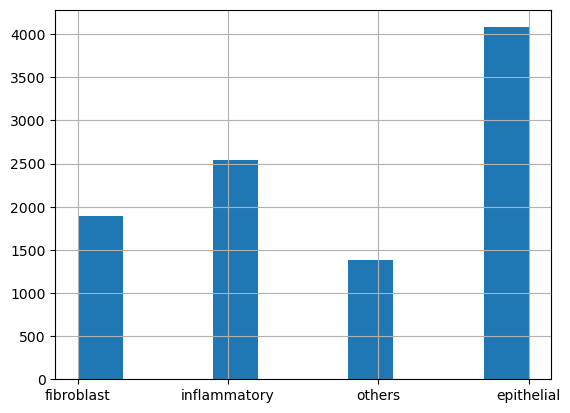

In [19]:
main_data.cellTypeName.hist()
plt.show()

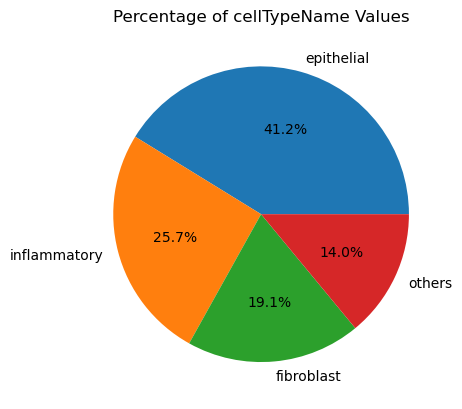

In [20]:
# Calculate the percentage of each 'isCancerousName' value
percentages = main_data['cellTypeName'].value_counts(normalize=True) * 100

# Create a pie chart of the percentages
plt.pie(percentages.values, labels=percentages.index, autopct='%1.1f%%')
plt.title('Percentage of cellTypeName Values')
plt.show()

### 4.2.2 CellType Observations ### 
**Epithelial cells (41.2%)** are the most common value in the cellTypeName column, followed by **Inflammatory (25.7%)**, **Fibroblast (19.1%)**, and **Others (14.0%)** cell types.

### 4.2.3 IsCancerous Exploration ### 
Looking at label distribution, `isCancerous` from `main_data`.

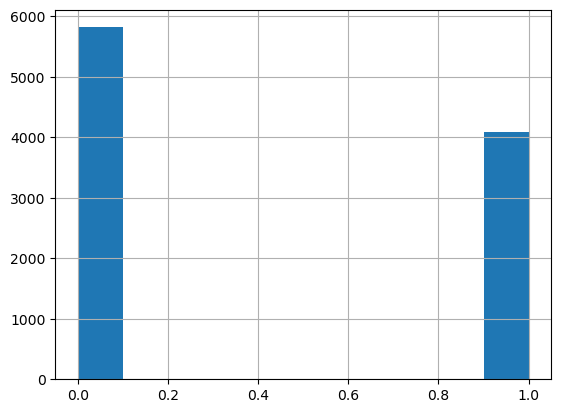

In [21]:
main_data.isCancerous.hist()
plt.show()

### 4.2.4 isCancerous Observations ###
* 'isCancerous' only has two classes (Binary)
* There are **more** **Not Cancerous** cells (approx. 5750 cells) than **Cancerous Cells** (approx. 4000 cells).

## 4.3 Identifying Correlations
### 4.3.1 Heatmap

/var/folders/6m/62xp3dss0hsc457x_8mc9nmh0000gn/T/ipykernel_95518/1377662766.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataframe.corr(),


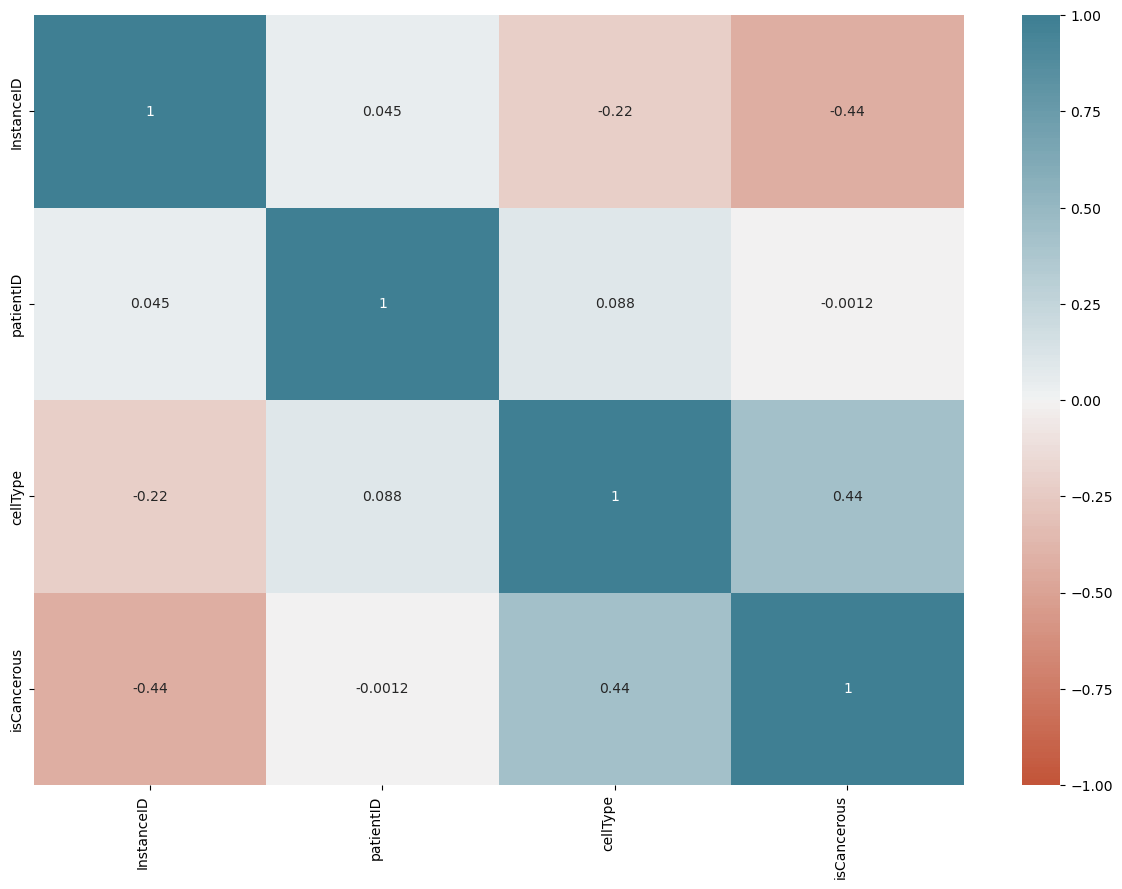

In [22]:
# Adapted from RMIT (2023) Week 3 Lab Exercises: Dataset splitting & Pre-Processing

import seaborn as sns

def GenerateHeatmap(dataframe):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(
        dataframe.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right'
    );
    
GenerateHeatmap(main_data)

/var/folders/6m/62xp3dss0hsc457x_8mc9nmh0000gn/T/ipykernel_95518/1377662766.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataframe.corr(),


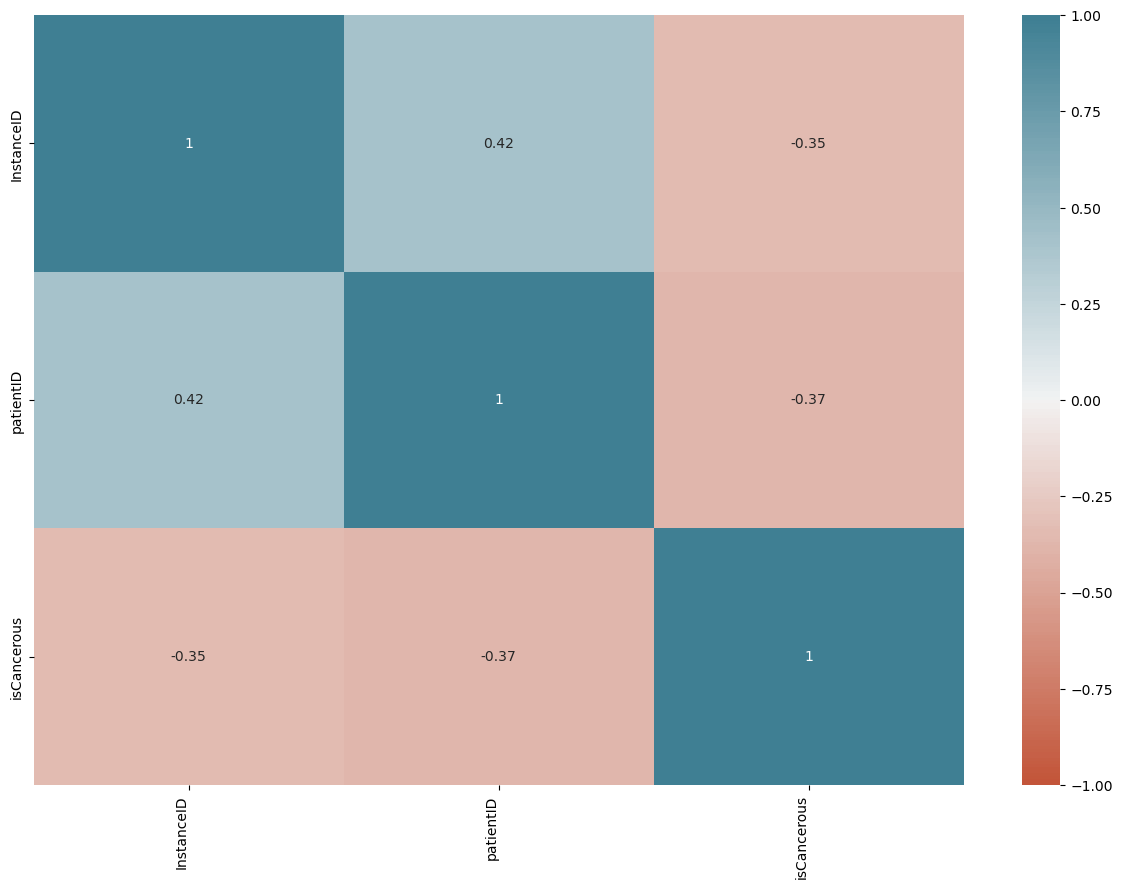

In [23]:
GenerateHeatmap(extra_data)

### 4.3.2 Heatmap Analysis
From the heatmap above, we can see there are no clear **strong** correlations between any of our data attributes. 

In order to use the extraData.csv data, we need to look for any correlations between the `isCancerous` column and another attribute within main_data.

### 4.3.3 Cancerous and Cell Type Relationship
#### 4.3.3.1 Non-Cancerous Cell Types
Create a dataframe which contains only **non-cancerous** cells.

In [24]:
#Dataframe with only the cancerous cells in 'main_data'
nonCancerous_main_data = main_data[main_data['isCancerous'] == 0]

Display the *categorical* **cellTypeName** column from the newly created dataframe as a **pie chart** to identify the distribution of **non-cancerous** cells.

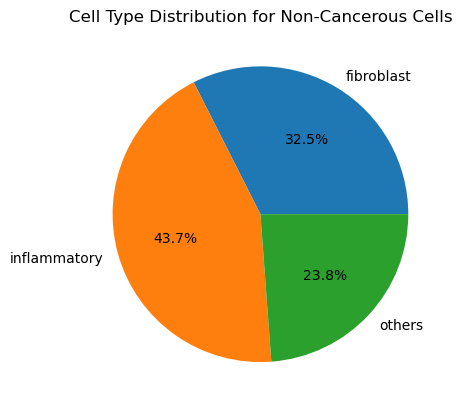

In [25]:
def GeneratePieChart(dataframe, columnName, title):
    # group the data by columnName and count the number of instances for each type
    grouped_data = dataframe.groupby(columnName).size().reset_index(name='counts')

    # create a pie chart using the 'counts' column and label it with the given columnName
    plt.pie(grouped_data['counts'], labels=grouped_data[columnName], autopct='%1.1f%%')
    plt.title(title)
    plt.show()
    
GeneratePieChart(nonCancerous_main_data, 'cellTypeName', "Cell Type Distribution for Non-Cancerous Cells")

We can see that all **non-cancerous** cells in `main data` belong to the **inflammatory, fibroblast, or others** cell type.

**Inflammatory (43.7%)** is the most common **non-cancerous** cell-type, followed by **fibroblast (32.5%)**, then **others (23.8%).**

#### 4.3.3.2 Cancerous Cell Types
Create a dataframe which contains only **cancerous** cells.

In [26]:
cancerous_main_data = main_data[main_data['isCancerous'] == 1]
cancerous_main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,isCancerousName
449,276,5,276.png,epithelial,2,1,Cancerous
450,277,5,277.png,epithelial,2,1,Cancerous
451,278,5,278.png,epithelial,2,1,Cancerous
452,279,5,279.png,epithelial,2,1,Cancerous
453,280,5,280.png,epithelial,2,1,Cancerous
...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,Cancerous
9892,1626,60,1626.png,epithelial,2,1,Cancerous
9893,1627,60,1627.png,epithelial,2,1,Cancerous
9894,1628,60,1628.png,epithelial,2,1,Cancerous


Display the *categorical* **cellTypeName** column from the newly created dataframe as a **pie chart** to identify the distribution of **cancerous** cells.

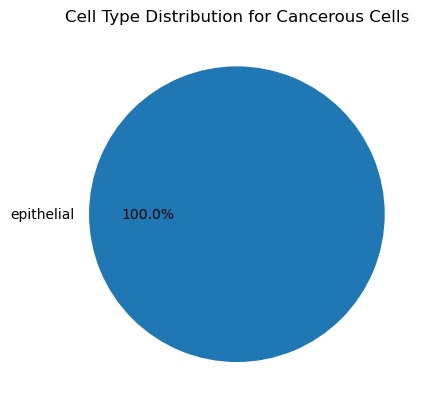

In [27]:
GeneratePieChart(cancerous_main_data, 'cellTypeName', "Cell Type Distribution for Cancerous Cells")

We can see that all **cancerous** cells in `main data` belong to the **epithelial (100%)** cell type.

## 4.4 Extra Data

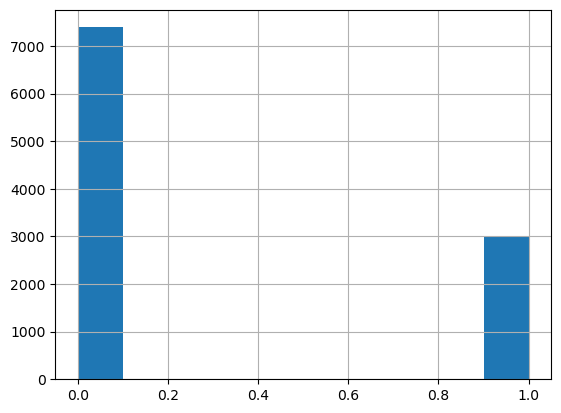

In [28]:
extra_data.isCancerous.hist()
plt.show()

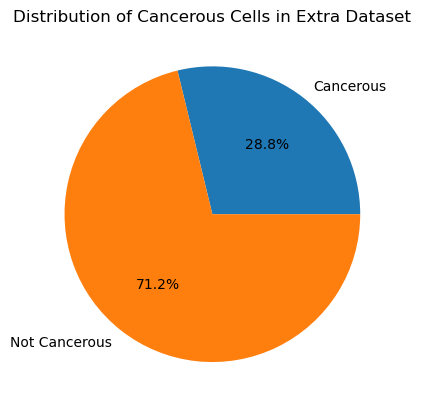

In [29]:
GeneratePieChart(extra_data, 'isCancerousName', "Distribution of Cancerous Cells in Extra Dataset")

From the above charts, we can see that **71.2%** of the cells in the `extra_data` set are **Not Cancerous**, with only **28.8%** of the data being **Cancerous**.

# 5. Combining Data Sets

## 5.1 Converting Binary Data to Strings

In [30]:
# Set Binary data to Strings to be used in the following machine learning models
main_data["isCancerous"] = main_data["isCancerous"].astype(str)
extra_data["isCancerous"] = extra_data["isCancerous"].astype(str)

## 5.2 Extrapolate cellType Attribute from Extra Data
*Based on the earlier analysis,* a subset of extra_data containing only the cancerous cells can be combined with image_data and main_data for the `cellType` model after adding an extrapolated cellType column *(i.e. if isCancerous == 1, then add the columns cellType = 2 & cellTypeName ='epithelial' )*.

In [31]:
# Make a copy of the cancerous (label 1) extra_data dataframe entries
extra_data_with_cellType = extra_data[extra_data['isCancerous'] == '1'].copy()

#add the columns 'cellType' = 2 & 'cellTypeName' ='epithelial' to the copy dataset
extra_data_with_cellType['cellType'] = '2'
extra_data_with_cellType['cellTypeName'] = 'epithelial'

extra_data = extra_data_with_cellType

## 5.3 Create Cell Type Model Dataset
Given that all three `image data`, `main data`, and `extra data` datasets contain **ImageName**, we will combine the two sets on this value.

In [32]:
# Datasets: image, main, and extra
# Contains: ImagePath, ImageName, cellType, cellTypeName

In [33]:
cellType_columns = ['ImageName', 'cellType', 'cellTypeName']

In [34]:
temp_main = main_data[cellType_columns].copy()
temp_main

,ImageName,cellType,cellTypeName
0,22405.png,0,fibroblast
1,22406.png,0,fibroblast
2,22407.png,0,fibroblast
3,22408.png,0,fibroblast
4,22409.png,0,fibroblast
...,...,...,...
9891,1625.png,2,epithelial
9892,1626.png,2,epithelial
9893,1627.png,2,epithelial
9894,1628.png,2,epithelial


In [35]:
temp_extra = extra_data[cellType_columns].copy()
temp_extra

,ImageName,cellType,cellTypeName
62,12748.png,2,epithelial
63,12749.png,2,epithelial
64,12750.png,2,epithelial
65,12751.png,2,epithelial
66,12752.png,2,epithelial
...,...,...,...
7800,7667.png,2,epithelial
7801,7668.png,2,epithelial
7802,7669.png,2,epithelial
7803,7670.png,2,epithelial


In [36]:
# temp_main + temp_extra
temp_join_data = [temp_main, temp_extra]
temp_cellTypeData = pd.concat(temp_join_data)
temp_cellTypeData

,ImageName,cellType,cellTypeName
0,22405.png,0,fibroblast
1,22406.png,0,fibroblast
2,22407.png,0,fibroblast
3,22408.png,0,fibroblast
4,22409.png,0,fibroblast
...,...,...,...
7800,7667.png,2,epithelial
7801,7668.png,2,epithelial
7802,7669.png,2,epithelial
7803,7670.png,2,epithelial


In [37]:
# Merge image_data with main and extra datasets
cellType_data = pd.merge(image_data, temp_cellTypeData, on='ImageName')
cellType_data

,ImagePath,ImageName,cellType,cellTypeName
0,./data/patch_images/3975.png,3975.png,3,others
1,./data/patch_images/8820.png,8820.png,2,epithelial
2,./data/patch_images/14392.png,14392.png,2,epithelial
3,./data/patch_images/9280.png,9280.png,2,epithelial
4,./data/patch_images/348.png,348.png,1,inflammatory
...,...,...,...,...
12881,./data/patch_images/13382.png,13382.png,0,fibroblast
12882,./data/patch_images/351.png,351.png,1,inflammatory
12883,./data/patch_images/437.png,437.png,2,epithelial
12884,./data/patch_images/6814.png,6814.png,2,epithelial


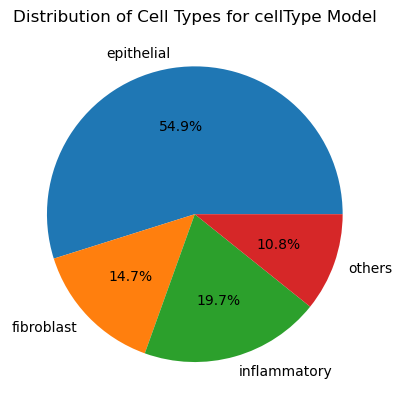

In [38]:
GeneratePieChart(cellType_data, 'cellTypeName', 'Distribution of Cell Types for cellType Model')

## 5.4 Create Cancerous Model Dataset
Extra_Data can be used with the combined image_data and main_data for `isCancerous` model.

Datasets to be joined: **image_data, main_data, and extra_data**

Attributes to include: **ImagePath, ImageName, isCancerous, isCancerousName**

### 5.4.1 Restrict Data to Required Columns

In [39]:
isCancerous_columns = ['ImageName', 'isCancerous', 'isCancerousName']

In [40]:
temp_main = main_data[isCancerous_columns].copy()
temp_main

,ImageName,isCancerous,isCancerousName
0,22405.png,0,Not Cancerous
1,22406.png,0,Not Cancerous
2,22407.png,0,Not Cancerous
3,22408.png,0,Not Cancerous
4,22409.png,0,Not Cancerous
...,...,...,...
9891,1625.png,1,Cancerous
9892,1626.png,1,Cancerous
9893,1627.png,1,Cancerous
9894,1628.png,1,Cancerous


### 5.4.2 Merge Datasets 

In [41]:
temp_extra = extra_data[isCancerous_columns].copy()
temp_extra

,ImageName,isCancerous,isCancerousName
62,12748.png,1,Cancerous
63,12749.png,1,Cancerous
64,12750.png,1,Cancerous
65,12751.png,1,Cancerous
66,12752.png,1,Cancerous
...,...,...,...
7800,7667.png,1,Cancerous
7801,7668.png,1,Cancerous
7802,7669.png,1,Cancerous
7803,7670.png,1,Cancerous


Combine the rows of the restricted `main` and `extra` data sets.

In [42]:
# Combine the rows of temp_main + temp_extra
temp_join_data = [temp_main, temp_extra]
temp_cancerousData = pd.concat(temp_join_data)
temp_cancerousData

,ImageName,isCancerous,isCancerousName
0,22405.png,0,Not Cancerous
1,22406.png,0,Not Cancerous
2,22407.png,0,Not Cancerous
3,22408.png,0,Not Cancerous
4,22409.png,0,Not Cancerous
...,...,...,...
7800,7667.png,1,Cancerous
7801,7668.png,1,Cancerous
7802,7669.png,1,Cancerous
7803,7670.png,1,Cancerous


In [43]:
# Merge image_data with main and extra datasets
isCancerous_data = pd.merge(image_data, temp_cancerousData, on='ImageName')
isCancerous_data

,ImagePath,ImageName,isCancerous,isCancerousName
0,./data/patch_images/3975.png,3975.png,0,Not Cancerous
1,./data/patch_images/8820.png,8820.png,1,Cancerous
2,./data/patch_images/14392.png,14392.png,1,Cancerous
3,./data/patch_images/9280.png,9280.png,1,Cancerous
4,./data/patch_images/348.png,348.png,0,Not Cancerous
...,...,...,...,...
12881,./data/patch_images/13382.png,13382.png,0,Not Cancerous
12882,./data/patch_images/351.png,351.png,0,Not Cancerous
12883,./data/patch_images/437.png,437.png,1,Cancerous
12884,./data/patch_images/6814.png,6814.png,1,Cancerous


Check the distribution of cancerous cells in the newly created `isCancerous_data` dataset.

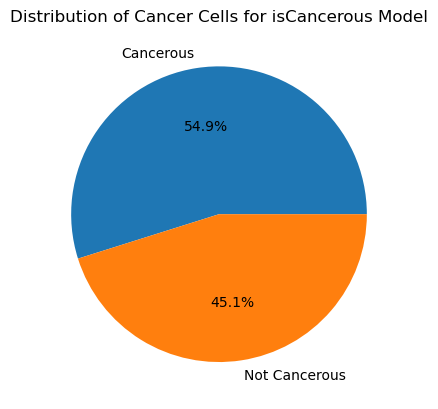

In [44]:
GeneratePieChart(isCancerous_data, 'isCancerousName', 'Distribution of Cancer Cells for isCancerous Model')

# 6. Cancerous Cells Baseline Model
The models considered for the baseline `isCancerous` prediction model were:

 * Neural Networks (NN)
    * Work well to make predictions on external data
    * Scalable to be used with large data sets
    * Effective for classifying data into multiple categories

 * Convolutional Neural Networks (CNN)
    * Good at identifying image features
    * They are effective for  image recognition as they are translation invariant
    * They are good at dealing with large and complex datasets

 * K-Nearest Neighbours (KNN)
    * KNNs are preferred when the data is low dimensional and the number of features is small
    * They are useful when the data is separable by a distance
    * Computationally expensive for large datasets

 * Random Forest Classifier (RFC)
    * Good at dealing with large and complex datasets.
    * Good for image tasks with lots of features
    * Strong at identifying the most important features
    
Given that the Cancerous Cells model has a small number of features, the we will first look at the KNN model.

## 6.1 K-Nearest Neighbours (KNN) Cancerous Cell Model
### 6.1.1 Extract Features

In [45]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def extract_features(image_path):
    image = Image.open(image_path)
    # Convert the image to grayscale
    gray_image = image.convert('L')
    # Calculate the histogram of oriented gradients (HOG) features
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
    return hog_features

# Extract the features for each image
features = []
for image_path in isCancerous_data["ImagePath"]:
    features.append(extract_features(image_path))
# Convert the features list to a numpy array
features = np.array(features)

# Load the labels for each image
labels = isCancerous_data['isCancerousName'].values

### 6.1.2 Split Data

In [46]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

### 6.1.3 Create and Fit Model

In [47]:
# Create a random forest classifier with 100 trees
knn = KNeighborsClassifier(3)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### 6.1.4 Make Predictions

In [48]:
# Use the classifier to make predictions on the testing data
y_pred = knn.predict(X_test)

### 6.1.5 Measure Success

In [49]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

cr = classification_report(y_test, y_pred, digits=3)
print('\nClassification Report:')
print(cr)

Accuracy: 0.6283941039565555

Classification Report:
               precision    recall  f1-score   support

    Cancerous      0.610     0.839     0.706      1373
Not Cancerous      0.679     0.388     0.494      1205

     accuracy                          0.628      2578
    macro avg      0.645     0.614     0.600      2578
 weighted avg      0.642     0.628     0.607      2578



## 6.2 Random Forest Classifier Cancerous Cell Model

In [50]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def extract_features(image_path):
    image = Image.open(image_path)
    # Convert the image to grayscale
    gray_image = image.convert('L')
    # Calculate the histogram of oriented gradients (HOG) features
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
    return hog_features

# Extract the features for each image
features = []
for image_path in isCancerous_data["ImagePath"]:
    features.append(extract_features(image_path))
# Convert the features list to a numpy array
features = np.array(features)

# Load the labels for each image
labels = isCancerous_data['isCancerousName'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Use the classifier to make predictions on the testing data
y_pred = rfc.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

cr = classification_report(y_test, y_pred, digits=3)
print('\nClassification Report:')
print(cr)

Accuracy: 0.6861908456167571

Classification Report:
               precision    recall  f1-score   support

    Cancerous      0.672     0.802     0.731      1373
Not Cancerous      0.711     0.554     0.623      1205

     accuracy                          0.686      2578
    macro avg      0.691     0.678     0.677      2578
 weighted avg      0.690     0.686     0.681      2578



## 6.4 Convolutional Neural Networks (CNN) Cancerous Cell Model

### 6.4.1 Split Cancerous Cell Data into Train, Validation, & Test Data

In [51]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(isCancerous_data, test_size=0.2, random_state=0) 
train, val = train_test_split(train, test_size=0.25, random_state=0)

print("Training data: ", train.shape[0]) #60% of our X_ and y_
print("Testing data: ", test.shape[0]) #20% of our X_ and y_
print("Validation data: ", val.shape[0]) #20% of our X_ and y_

Training data:  7731
Testing data:  2578
Validation data:  2577


### 6.4.2 Data loader

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerousName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerousName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 2 classes.
Found 2577 validated image filenames belonging to 2 classes.


### 6.4.3 Setting up base model

In [53]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))])

2023-05-16 20:08:28.563258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cnn = model_cnn.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150


/Users/eivy/anaconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


242/242 [==============================] - 2s 7ms/step - loss: 0.6580 - categorical_accuracy: 0.6497 - val_loss: 0.4626 - val_categorical_accuracy: 0.8048
Epoch 2/150
242/242 [==============================] - 2s 7ms/step - loss: 0.4587 - categorical_accuracy: 0.8143 - val_loss: 0.3759 - val_categorical_accuracy: 0.8537
Epoch 3/150
242/242 [==============================] - 2s 6ms/step - loss: 0.4082 - categorical_accuracy: 0.8381 - val_loss: 0.3624 - val_categorical_accuracy: 0.8549
Epoch 4/150
242/242 [==============================] - 2s 6ms/step - loss: 0.3803 - categorical_accuracy: 0.8490 - val_loss: 0.3473 - val_categorical_accuracy: 0.8634
Epoch 5/150
242/242 [==============================] - 2s 6ms/step - loss: 0.3718 - categorical_accuracy: 0.8560 - val_loss: 0.3532 - val_categorical_accuracy: 0.8622
Epoch 6/150
242/242 [==============================] - 2s 6ms/step - loss: 0.3554 - categorical_accuracy: 0.8657 - val_loss: 0.3274 - val_categorical_accuracy: 0.8688
Epoch 7/15

Epoch 50/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1585 - categorical_accuracy: 0.9528 - val_loss: 0.4260 - val_categorical_accuracy: 0.8673
Epoch 51/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1568 - categorical_accuracy: 0.9520 - val_loss: 0.4512 - val_categorical_accuracy: 0.8735
Epoch 52/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1515 - categorical_accuracy: 0.9511 - val_loss: 0.4098 - val_categorical_accuracy: 0.8774
Epoch 53/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1475 - categorical_accuracy: 0.9528 - val_loss: 0.4778 - val_categorical_accuracy: 0.8622
Epoch 54/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1455 - categorical_accuracy: 0.9534 - val_loss: 0.4892 - val_categorical_accuracy: 0.8638
Epoch 55/150
242/242 [==============================] - 2s 6ms/step - loss: 0.1468 - categorical_accuracy: 0.9555 - val_loss: 0.4521 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 2s 6ms/step - loss: 0.0781 - categorical_accuracy: 0.9840 - val_loss: 0.6202 - val_categorical_accuracy: 0.8653
Epoch 100/150
242/242 [==============================] - 2s 6ms/step - loss: 0.0670 - categorical_accuracy: 0.9878 - val_loss: 0.6357 - val_categorical_accuracy: 0.8727
Epoch 101/150
242/242 [==============================] - 2s 6ms/step - loss: 0.0710 - categorical_accuracy: 0.9886 - val_loss: 0.6352 - val_categorical_accuracy: 0.8650
Epoch 102/150
242/242 [==============================] - 2s 6ms/step - loss: 0.0792 - categorical_accuracy: 0.9818 - val_loss: 0.6258 - val_categorical_accuracy: 0.8688
Epoch 103/150
242/242 [==============================] - 2s 6ms/step - loss: 0.0746 - categorical_accuracy: 0.9842 - val_loss: 0.5857 - val_categorical_accuracy: 0.8700
Epoch 104/150
242/242 [==============================] - 2s 8ms/step - loss: 0.0684 - categorical_accuracy: 0.9871 - val_loss: 0.7247 - val_categorical_accu

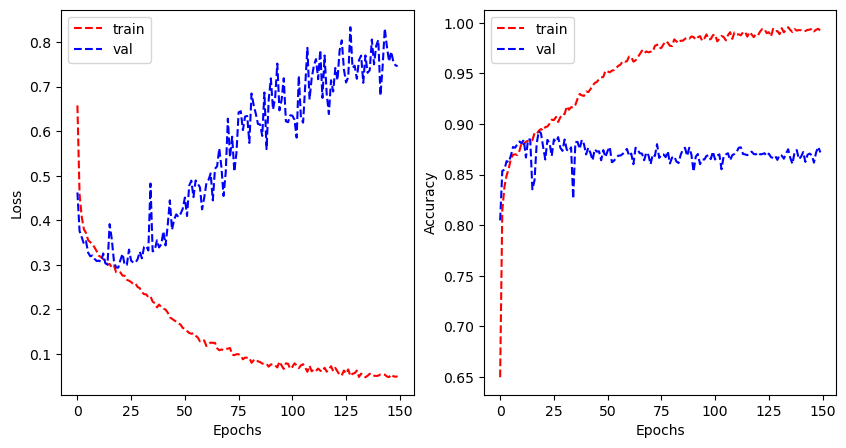

In [55]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], 'r--')
plt.plot(history_cnn.history['val_loss'], 'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cnn.history['categorical_accuracy'], 'r--')
plt.plot(history_cnn.history['val_categorical_accuracy'], 'b--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [56]:
# created a function to evaluate the accuracy and loss of models

from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_scores(inputData, target_model, target_col, model_name):
    print(model_name, "Model scores:")
    
    test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    
    test_generator = test_datagen.flow_from_dataframe(
            dataframe=inputData,
            directory='./',
            x_col="ImagePath",
            y_col=target_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='categorical')
    
    test_loss, test_acc = target_model.evaluate(test_generator, verbose=0)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    
    # Make predictions on the test set
    y_pred = target_model.predict(test_generator, verbose=1)
    predicted_labels = np.argmax(y_pred, axis=1)
    true_labels = test_generator.labels

    # Compute F1-score, precision and recall for each label
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    print("F1-score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)

In [57]:
evaluate_scores(test, model_cnn, "isCancerousName", "CNN Baseline isCancerous")

CNN Baseline isCancerous Model scores:
Found 2578 validated image filenames belonging to 2 classes.
Test loss: 0.6850984692573547
Test accuracy: 0.877036452293396
81/81 [==============================] - 0s 4ms/step
F1-score: 0.5014864229416014
Precision: 0.5014250122824856
Recall: 0.5015515903801396


The baseline CNN model above has a relatively high accuracy (~83%) but is heavily overfitting on the dataset as illustrated by the Loss figure above.

### 6.4.4 Data Augmentation
In order to reduce **overfitting** in our CNN model, we will apply **Data Augmentation** to the **CNN model**.

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col="ImagePath",
    y_col="isCancerousName",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory='./',
    x_col="ImagePath",
    y_col="isCancerousName",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')


Found 7731 validated image filenames belonging to 2 classes.
Found 2577 validated image filenames belonging to 2 classes.


In [59]:
model_cnn_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cnn_aug.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cnn_aug = model_cnn_aug.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6985 - categorical_accuracy: 0.6019 - val_loss: 0.7735 - val_categorical_accuracy: 0.5534
Epoch 2/150
242/242 [==============================] - 3s 13ms/step - loss: 0.7093 - categorical_accuracy: 0.5850 - val_loss: 0.7215 - val_categorical_accuracy: 0.5534
Epoch 3/150
242/242 [==============================] - 3s 13ms/step - loss: 0.7183 - categorical_accuracy: 0.5519 - val_loss: 0.7165 - val_categorical_accuracy: 0.5534
Epoch 4/150
242/242 [==============================] - 3s 13ms/step - loss: 0.7025 - categorical_accuracy: 0.5770 - val_loss: 0.6068 - val_categorical_accuracy: 0.7163
Epoch 5/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6865 - categorical_accuracy: 0.6170 - val_loss: 0.7119 - val_categorical_accuracy: 0.5534
Epoch 6/150
242/242 [==============================] - 3s 13ms/step - loss: 0.7118 - categorical_accuracy: 0.5523 - val_loss: 0.7097 - val_categorical_accuracy:

242/242 [==============================] - 3s 13ms/step - loss: 0.3298 - categorical_accuracy: 0.8692 - val_loss: 0.2989 - val_categorical_accuracy: 0.8824
Epoch 98/150
242/242 [==============================] - 3s 13ms/step - loss: 0.3308 - categorical_accuracy: 0.8695 - val_loss: 0.3132 - val_categorical_accuracy: 0.8789
Epoch 99/150
242/242 [==============================] - 3s 13ms/step - loss: 0.3261 - categorical_accuracy: 0.8732 - val_loss: 0.3198 - val_categorical_accuracy: 0.8813
Epoch 100/150
242/242 [==============================] - 3s 13ms/step - loss: 0.3296 - categorical_accuracy: 0.8685 - val_loss: 0.3153 - val_categorical_accuracy: 0.8704
Epoch 101/150
242/242 [==============================] - 3s 13ms/step - loss: 0.3310 - categorical_accuracy: 0.8677 - val_loss: 0.3051 - val_categorical_accuracy: 0.8735
Epoch 102/150
242/242 [==============================] - 3s 13ms/step - loss: 0.3300 - categorical_accuracy: 0.8675 - val_loss: 0.3020 - val_categorical_accuracy: 0.8

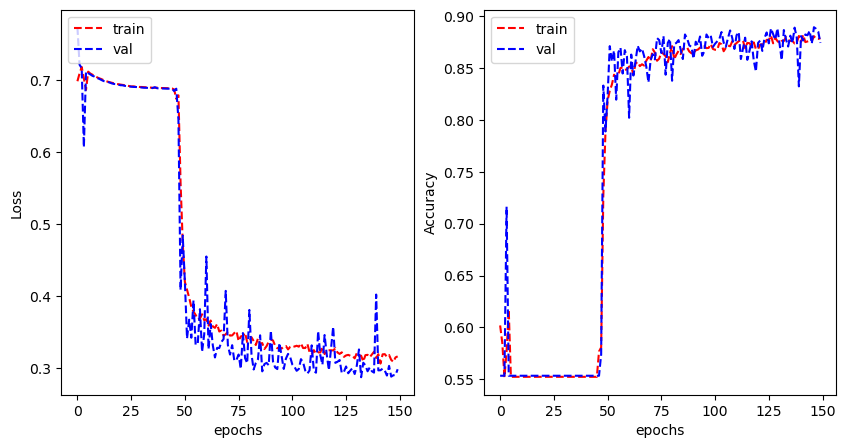

In [60]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cnn_aug.history['loss'], 'r--')
plt.plot(history_cnn_aug.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cnn_aug.history['categorical_accuracy'], 'r--')
plt.plot(history_cnn_aug.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [61]:
evaluate_scores(test, model_cnn_aug, "isCancerousName", "Data Augmentated CNN isCancerous")

Data Augmentated CNN isCancerous Model scores:
Found 2578 validated image filenames belonging to 2 classes.
Test loss: 0.2908979058265686
Test accuracy: 0.8797517418861389
81/81 [==============================] - 0s 4ms/step
F1-score: 0.5120739870876678
Precision: 0.5116724261836941
Recall: 0.5128006206361521


## 6.5 Neural Networks (NN) Cancerous Cell Model

### 6.5.1 Set up the layers

In [62]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256

# Two output classes for isCancerous. Either 0 or 1
OUTPUT_CLASSES = 2 

### 6.5.2 Build Model

In [63]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [64]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2187)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               560128    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


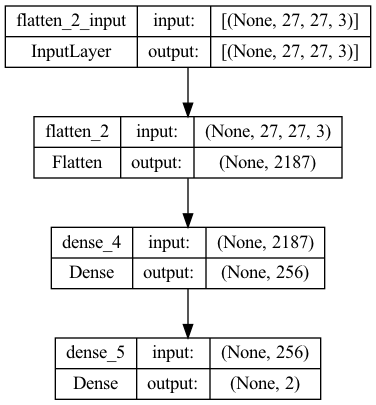

In [65]:
tf.keras.utils.plot_model(nn_model, show_shapes=True)

### 6.5.3 Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [66]:
nn_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### 6.5.4 Data loader

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerousName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerousName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 2 classes.
Found 2577 validated image filenames belonging to 2 classes.


### 6.5.5 Model Training

In [68]:
history = nn_model.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 6ms/step - loss: 0.6307 - categorical_accuracy: 0.6669 - val_loss: 0.5704 - val_categorical_accuracy: 0.6345
Epoch 2/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5031 - categorical_accuracy: 0.8111 - val_loss: 0.4482 - val_categorical_accuracy: 0.8545
Epoch 3/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4207 - categorical_accuracy: 0.8560 - val_loss: 0.3840 - val_categorical_accuracy: 0.8754
Epoch 4/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3681 - categorical_accuracy: 0.8688 - val_loss: 0.3503 - val_categorical_accuracy: 0.8696
Epoch 5/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3354 - categorical_accuracy: 0.8739 - val_loss: 0.3908 - val_categorical_accuracy: 0.8234
Epoch 6/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3154 - categorical_accuracy: 0.8791 - val_loss: 0.3035 - val_categorical_accuracy: 0.884

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2484 - categorical_accuracy: 0.8969 - val_loss: 0.3007 - val_categorical_accuracy: 0.8731
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2467 - categorical_accuracy: 0.8973 - val_loss: 0.2619 - val_categorical_accuracy: 0.8809
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2477 - categorical_accuracy: 0.8998 - val_loss: 0.2649 - val_categorical_accuracy: 0.8859
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2505 - categorical_accuracy: 0.8994 - val_loss: 0.2642 - val_categorical_accuracy: 0.8855
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2511 - categorical_accuracy: 0.8965 - val_loss: 0.2802 - val_categorical_accuracy: 0.8820
Epoch 55/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2483 - categorical_accuracy: 0.8943 - val_loss: 0.2674 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2396 - categorical_accuracy: 0.9025 - val_loss: 0.2627 - val_categorical_accuracy: 0.8832
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2363 - categorical_accuracy: 0.9040 - val_loss: 0.3255 - val_categorical_accuracy: 0.8584
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2372 - categorical_accuracy: 0.9018 - val_loss: 0.2960 - val_categorical_accuracy: 0.8754
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2355 - categorical_accuracy: 0.9042 - val_loss: 0.2867 - val_categorical_accuracy: 0.8789
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2384 - categorical_accuracy: 0.9012 - val_loss: 0.2614 - val_categorical_accuracy: 0.8851
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2401 - categorical_accuracy: 0.9031 - val_loss: 0.2582 - val_categorical_accu

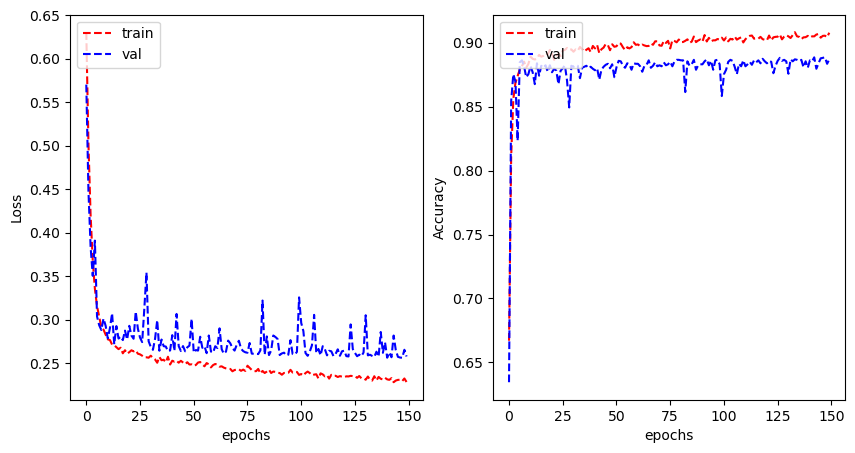

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on Base Model:**
* Loss function outputted an overlap between train and validation set at approximately 0.35 (a lower value suggests that the model's predictions are quite good) and gets inceasingly better with every increase of epoch(s).
* Overfitting occurred as the training accuracy indicates that the model makes increasingly better predictions as the number of epochs rises. Whereas, the validation accuracy indicates that the model is more likely to make more errors in its predictions on the validation set compared to the training set, which could mean that the model was overfitted to the training set.

In [70]:
evaluate_scores(test, nn_model, "isCancerousName", "Baseline NN isCancerous")

Baseline NN isCancerous Model scores:
Found 2578 validated image filenames belonging to 2 classes.
Test loss: 0.24120880663394928
Test accuracy: 0.9010860919952393
81/81 [==============================] - 0s 4ms/step
F1-score: 0.49336200315599654
Precision: 0.49281871296093044
Recall: 0.4945694336695112


### 6.5.6 Creating table to show all baseline models' accuracies for Cancerous classification
Table created with 5 columns, 'Baseline Model', 'Accuracy Score', 'Weighted Average F1-Score', 'WA Precision', 'WA Recall' to show all model performance results for Cancerous cell classification.

In [71]:
# Weighted Average = WA

from tabulate import tabulate

info = [['K-Nearest Neigbors', 0.628, 0.607, 0.642, 0.628], ['Random Forest Classifier', 0.686, 0.681, 0.690, 0.686], ['Convolutional Neural Networks', 0.834, 0.518, 0.517, 0.518], ['Neural Networks', 0.821, 0.495, 0.497, 0.504]]
headers = ['Baseline Model', 'Accuracy Score', 'Weighted Average F1-Score', 'WA Precision', 'WA Recall']
table = tabulate(info, headers, tablefmt='orgtbl')
print(table)

| Baseline Model                |   Accuracy Score |   Weighted Average F1-Score |   WA Precision |   WA Recall |
|-------------------------------+------------------+-----------------------------+----------------+-------------|
| K-Nearest Neigbors            |            0.628 |                       0.607 |          0.642 |       0.628 |
| Random Forest Classifier      |            0.686 |                       0.681 |          0.69  |       0.686 |
| Convolutional Neural Networks |            0.834 |                       0.518 |          0.517 |       0.518 |
| Neural Networks               |            0.821 |                       0.495 |          0.497 |       0.504 |


### 6.5.8 Regularisation

In [72]:
reg_lambda = 0.01

nn_model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [73]:
nn_model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [74]:
# train regularised model
history_reg = nn_model_reg.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 6ms/step - loss: 5.0348 - categorical_accuracy: 0.6797 - val_loss: 4.7597 - val_categorical_accuracy: 0.8366
Epoch 2/150
242/242 [==============================] - 1s 5ms/step - loss: 4.5275 - categorical_accuracy: 0.8099 - val_loss: 4.2971 - val_categorical_accuracy: 0.8619
Epoch 3/150
242/242 [==============================] - 1s 5ms/step - loss: 4.0954 - categorical_accuracy: 0.8542 - val_loss: 3.9047 - val_categorical_accuracy: 0.8421
Epoch 4/150
242/242 [==============================] - 1s 5ms/step - loss: 3.7258 - categorical_accuracy: 0.8590 - val_loss: 3.5651 - val_categorical_accuracy: 0.8650
Epoch 5/150
242/242 [==============================] - 1s 5ms/step - loss: 3.3982 - categorical_accuracy: 0.8736 - val_loss: 3.2576 - val_categorical_accuracy: 0.8727
Epoch 6/150
242/242 [==============================] - 1s 5ms/step - loss: 3.1113 - categorical_accuracy: 0.8739 - val_loss: 2.9796 - val_categorical_accuracy: 0.877

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4228 - categorical_accuracy: 0.8919 - val_loss: 0.4647 - val_categorical_accuracy: 0.8537
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4211 - categorical_accuracy: 0.8910 - val_loss: 0.4429 - val_categorical_accuracy: 0.8727
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4168 - categorical_accuracy: 0.8898 - val_loss: 0.4228 - val_categorical_accuracy: 0.8813
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4122 - categorical_accuracy: 0.8911 - val_loss: 0.4266 - val_categorical_accuracy: 0.8758
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4116 - categorical_accuracy: 0.8910 - val_loss: 0.4177 - val_categorical_accuracy: 0.8836
Epoch 55/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4083 - categorical_accuracy: 0.8890 - val_loss: 0.4205 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3862 - categorical_accuracy: 0.8904 - val_loss: 0.3906 - val_categorical_accuracy: 0.8813
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3862 - categorical_accuracy: 0.8901 - val_loss: 0.3927 - val_categorical_accuracy: 0.8816
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3863 - categorical_accuracy: 0.8929 - val_loss: 0.3978 - val_categorical_accuracy: 0.8797
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3859 - categorical_accuracy: 0.8875 - val_loss: 0.3990 - val_categorical_accuracy: 0.8782
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3839 - categorical_accuracy: 0.8904 - val_loss: 0.3898 - val_categorical_accuracy: 0.8805
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3846 - categorical_accuracy: 0.8930 - val_loss: 0.3897 - val_categorical_accu

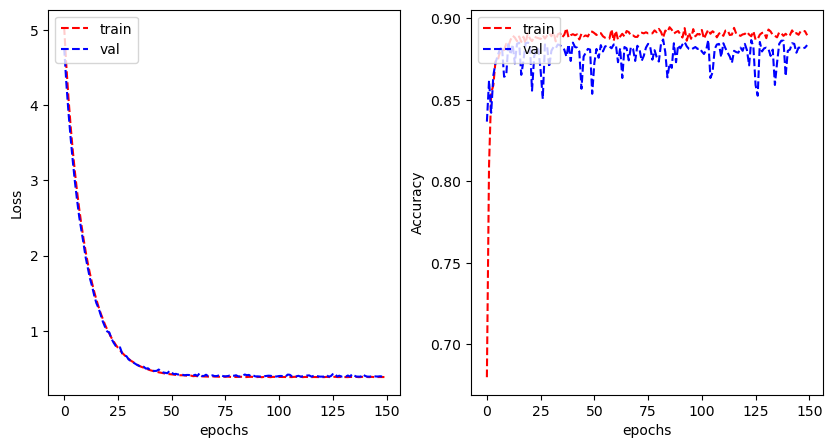

In [75]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on isCancerous CNN Model after Regularisation:**
* The loss function shows the Train and Validation data very closely tied after Regularisation
* The accuracy function shows us that overfitting has been drastically reduced from the base model with the validation data

In [76]:
evaluate_scores(test, nn_model_reg, "isCancerousName", "Regularised NN isCancerous")

Regularised NN isCancerous Model scores:
Found 2578 validated image filenames belonging to 2 classes.
Test loss: 0.3710971772670746
Test accuracy: 0.9034134745597839
81/81 [==============================] - 0s 4ms/step
F1-score: 0.5078185571367617
Precision: 0.5078829673717963
Recall: 0.5077579519006982


### 6.5.9 Dropout

In [77]:
reg_lambda = 0.01

nn_dropout_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [78]:
nn_dropout_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [79]:
history_drop = nn_dropout_model.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 6ms/step - loss: 0.6780 - categorical_accuracy: 0.5872 - val_loss: 0.5707 - val_categorical_accuracy: 0.6612
Epoch 2/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5431 - categorical_accuracy: 0.7453 - val_loss: 0.4703 - val_categorical_accuracy: 0.8568
Epoch 3/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4746 - categorical_accuracy: 0.7905 - val_loss: 0.4205 - val_categorical_accuracy: 0.8626
Epoch 4/150
242/242 [==============================] - 1s 5ms/step - loss: 0.4239 - categorical_accuracy: 0.8264 - val_loss: 0.3717 - val_categorical_accuracy: 0.8774
Epoch 5/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3880 - categorical_accuracy: 0.8392 - val_loss: 0.3445 - val_categorical_accuracy: 0.8778
Epoch 6/150
242/242 [==============================] - 1s 5ms/step - loss: 0.3679 - categorical_accuracy: 0.8497 - val_loss: 0.3265 - val_categorical_accuracy: 0.879

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2667 - categorical_accuracy: 0.8904 - val_loss: 0.2941 - val_categorical_accuracy: 0.8774
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2660 - categorical_accuracy: 0.8873 - val_loss: 0.2770 - val_categorical_accuracy: 0.8820
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2668 - categorical_accuracy: 0.8895 - val_loss: 0.2689 - val_categorical_accuracy: 0.8832
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2690 - categorical_accuracy: 0.8930 - val_loss: 0.2681 - val_categorical_accuracy: 0.8832
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2652 - categorical_accuracy: 0.8924 - val_loss: 0.2728 - val_categorical_accuracy: 0.8809
Epoch 55/150
242/242 [==============================] - 1s 6ms/step - loss: 0.2624 - categorical_accuracy: 0.8917 - val_loss: 0.2671 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2551 - categorical_accuracy: 0.8943 - val_loss: 0.2636 - val_categorical_accuracy: 0.8828
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2543 - categorical_accuracy: 0.8946 - val_loss: 0.2684 - val_categorical_accuracy: 0.8828
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2519 - categorical_accuracy: 0.8955 - val_loss: 0.2883 - val_categorical_accuracy: 0.8770
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2543 - categorical_accuracy: 0.8937 - val_loss: 0.2633 - val_categorical_accuracy: 0.8813
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2526 - categorical_accuracy: 0.8966 - val_loss: 0.2662 - val_categorical_accuracy: 0.8836
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.2555 - categorical_accuracy: 0.8947 - val_loss: 0.2630 - val_categorical_accu

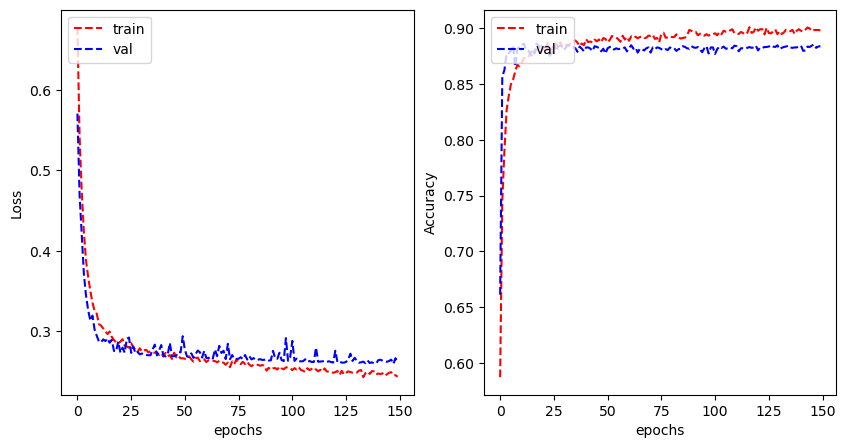

In [80]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on isCancerous CNN Model after Dropout (No Regularisation):**
* Loss function improved much more compared utilising regularisation
* The same observation can also be said for accuracy of the dropout model, that it has improved more so then with regularisation

In [81]:
evaluate_scores(test, nn_dropout_model, "isCancerousName", "Dropout NN isCancerous")

Dropout NN isCancerous Model scores:
Found 2578 validated image filenames belonging to 2 classes.
Test loss: 0.24202755093574524
Test accuracy: 0.9030256271362305
81/81 [==============================] - 0s 4ms/step
F1-score: 0.5127729045953633
Precision: 0.5123540498023869
Recall: 0.5135764158262219


## 6.6 Ultimate Judgement
In this section of the notebook, we have built and trained between four different types of supervised machine learning algorithms; KNN, Random Forest Classifier, CNN and NN to perform the task of distinguishing whether or not a cell is cancerous from images.

To decide which model is the "best", we based our criteria mainly on accuracy and f1-score, whereby convolutional neural networks model, that is, the regularised (data augmentation) CNN model had the most outstanding results with a loss function of 0.297, an accuracy of 0.889 and an f1-score of 0.513 compared to its baseline model which achieved 0.943, 0.834 and 0.518 respectively. In addition, it may be worth noting that the neural networks model type did considerably exceptional in both its baseline and dropout model achieving a loss function of 0.445 and 0.403, an accuracy of 0.821 and 0.836 and an f1-score of 0.495 and .484, accordingly. Having very similar baseline accuracy scores to CNN's baseline.

When making this ultimate judgement, we also conducted feature importance analysis when extracting data to select only those most useful and relevant to train the model as well as combining both the given main and extra data sets into one whole to maximise the model's performance for making predictions.

Therefore, we recommend using CNN for this particular project and underneath is a demonstration of our model's performance on predicting on unseen test data.

### 6.6.1 Save isCancerous Model

In [82]:
model_cnn_aug.save("isCancerous_model")

INFO:tensorflow:Assets written to: isCancerous_model/assets


INFO:tensorflow:Assets written to: isCancerous_model/assets


Load model:

In [83]:
isCancerous_model = tf.keras.models.load_model('isCancerous_model')

## 6.7 Model Test Predictions

In [84]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerousName",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2578 validated image filenames belonging to 2 classes.


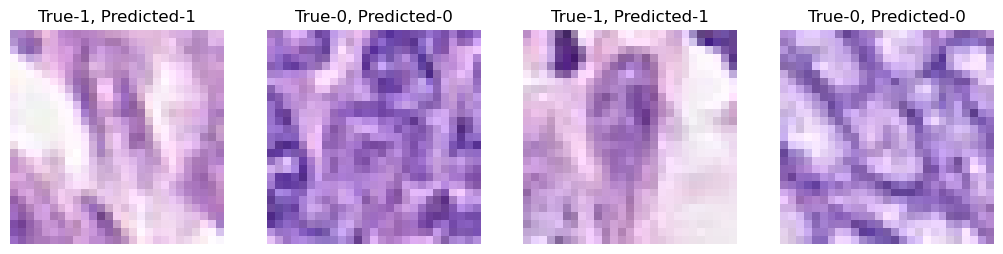

In [85]:
# baseline model predictions
label_strings_inv = {v: k for k, v in isCancerous_labels.items()}
pred_string_val = [label_strings_inv[isCancerous_labels[i]] for i in range(len(isCancerous_labels))]
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_pred = nn_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("True-{}, Predicted-{}".format(pred_string_val[np.argmax(y[0])], pred_string_val[np.argmax(y_pred[0])] ))
            
        else:
            break
        
        plt.axis('off')

# 7. Cell Type Baseline Model
The models considered for the baseline `cellType` prediction model were:

 * **Neural Networks (NN)**
    * Work well to make predictions on external data
    * Scalable to be used with large data sets
    * Effective for classifying data into multiple categories

 * **Convolutional Neural Networks (CNN)**
    * Good at identifying image features
    * They are effective for  image recognition as they are translation invariant
    * They are good at dealing with large and complex datasets

 * **K-Nearest Neighbours (KNN)**
    * KNNs are preferred when the data is low dimensional and the number of features is small
    * They are useful when the data is separable by a distance
    * Computationally expensive for large datasets

 * **Random Forest Classifier (RFC)**
    * Good at dealing with large and complex datasets.
    * Good for image tasks with lots of features
    * Strong at identifying the most important features

Given that the number of features in our dataset is small, we will first try the **KNN** model.

## 7.1 KNN Cell Type Model

In [86]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def extract_features(image_path):
    image = Image.open(image_path)
    # Convert the image to grayscale
    gray_image = image.convert('L')
    # Calculate the histogram of oriented gradients (HOG) features
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
    return hog_features

# Extract the features for each image
features = []
for image_path in cellType_data['ImagePath']:
    features.append(extract_features(image_path))
# Convert the features list to a numpy array
features = np.array(features)

# Load the labels for each image
labels = cellType_data['cellTypeName'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Create a random forest classifier with 100 trees
knn_model = KNeighborsClassifier(3)

# Fit the classifier to the training data
knn_model.fit(X_train, y_train)

# Use the classifier to make predictions on the testing data
y_pred = knn_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

cr = classification_report(y_test, y_pred, digits=3)
print('\nClassification Report:')
print(cr)

Accuracy: 0.5640031031807603

Classification Report:
              precision    recall  f1-score   support

  epithelial      0.586     0.910     0.713      1373
  fibroblast      0.475     0.361     0.410       371
inflammatory      0.554     0.104     0.175       539
      others      0.230     0.047     0.079       295

    accuracy                          0.564      2578
   macro avg      0.461     0.356     0.344      2578
weighted avg      0.523     0.564     0.484      2578



## 7.2 Random Forest Classifier Cell Type Model

In [87]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def extract_features(image_path):
    image = Image.open(image_path)
    # Convert the image to grayscale
    gray_image = image.convert('L')
    # Calculate the histogram of oriented gradients (HOG) features
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
    return hog_features

# Extract the features for each image
features = []
for image_path in cellType_data['ImagePath']:
    features.append(extract_features(image_path))
# Convert the features list to a numpy array
features = np.array(features)

# Load the labels for each image
labels = cellType_data['cellTypeName'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Create a random forest classifier with 100 trees
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the classifier to the training data
rfc_model.fit(X_train, y_train)

# Use the classifier to make predictions on the testing data
y_pred = rfc_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

cr = classification_report(y_test, y_pred, digits=3)
print('\nClassification Report:')
print(cr)

Accuracy: 0.6051202482544609

Classification Report:
              precision    recall  f1-score   support

  epithelial      0.597     0.966     0.738      1373
  fibroblast      0.695     0.313     0.431       371
inflammatory      0.619     0.217     0.321       539
      others      0.500     0.003     0.007       295

    accuracy                          0.605      2578
   macro avg      0.603     0.375     0.374      2578
weighted avg      0.605     0.605     0.523      2578



## 7.3 CNN Cell Type Model

### 7.3.1 Split Data into Train, Test & Validation Data

In [88]:
from sklearn.model_selection import train_test_split

ct_train, ct_test = train_test_split(cellType_data, test_size=0.2, random_state=0) 
ct_train, ct_val = train_test_split(ct_train, test_size=0.25, random_state=0)

print("Training Data:", ct_train.shape[0]) #60% of our X_ and y_
print("Testing Data:", ct_test.shape[0]) #20% of our X_ and y_
print("Validation Data:", ct_val.shape[0]) #20% of our X_ and y_ 

Training Data: 7731
Testing Data: 2578
Validation Data: 2577


### 7.3.2 Data Loader

In [89]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=ct_train,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        dataframe=ct_val,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 4 classes.
Found 2577 validated image filenames belonging to 4 classes.


### 7.3.3 Setting up base model

In [90]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

ct_model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))])

In [91]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
ct_model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

/Users/eivy/anaconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [92]:
ct_history_leNet = ct_model_leNet.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 9ms/step - loss: 1.1773 - categorical_accuracy: 0.5607 - val_loss: 0.9819 - val_categorical_accuracy: 0.6116
Epoch 2/150
242/242 [==============================] - 2s 9ms/step - loss: 0.8912 - categorical_accuracy: 0.6717 - val_loss: 0.7702 - val_categorical_accuracy: 0.7187
Epoch 3/150
242/242 [==============================] - 2s 8ms/step - loss: 0.7986 - categorical_accuracy: 0.7100 - val_loss: 0.7569 - val_categorical_accuracy: 0.7035
Epoch 4/150
242/242 [==============================] - 2s 8ms/step - loss: 0.7777 - categorical_accuracy: 0.7166 - val_loss: 0.6971 - val_categorical_accuracy: 0.7346
Epoch 5/150
242/242 [==============================] - 2s 8ms/step - loss: 0.7402 - categorical_accuracy: 0.7266 - val_loss: 0.6652 - val_categorical_accuracy: 0.7501
Epoch 6/150
242/242 [==============================] - 2s 7ms/step - loss: 0.7348 - categorical_accuracy: 0.7291 - val_loss: 0.6676 - val_categorical_accuracy: 0.750

Epoch 50/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3798 - categorical_accuracy: 0.8686 - val_loss: 0.8131 - val_categorical_accuracy: 0.7501
Epoch 51/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3810 - categorical_accuracy: 0.8657 - val_loss: 0.8099 - val_categorical_accuracy: 0.7482
Epoch 52/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3706 - categorical_accuracy: 0.8745 - val_loss: 0.7807 - val_categorical_accuracy: 0.7536
Epoch 53/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3613 - categorical_accuracy: 0.8772 - val_loss: 0.8473 - val_categorical_accuracy: 0.7532
Epoch 54/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3653 - categorical_accuracy: 0.8731 - val_loss: 0.8570 - val_categorical_accuracy: 0.7338
Epoch 55/150
242/242 [==============================] - 2s 7ms/step - loss: 0.3367 - categorical_accuracy: 0.8850 - val_loss: 0.8570 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 2s 7ms/step - loss: 0.2019 - categorical_accuracy: 0.9413 - val_loss: 1.3318 - val_categorical_accuracy: 0.7478
Epoch 100/150
242/242 [==============================] - 2s 7ms/step - loss: 0.2165 - categorical_accuracy: 0.9395 - val_loss: 1.2766 - val_categorical_accuracy: 0.7388
Epoch 101/150
242/242 [==============================] - 2s 7ms/step - loss: 0.2051 - categorical_accuracy: 0.9389 - val_loss: 1.2800 - val_categorical_accuracy: 0.7326
Epoch 102/150
242/242 [==============================] - 2s 7ms/step - loss: 0.1975 - categorical_accuracy: 0.9431 - val_loss: 1.3027 - val_categorical_accuracy: 0.7458
Epoch 103/150
242/242 [==============================] - 2s 7ms/step - loss: 0.2004 - categorical_accuracy: 0.9426 - val_loss: 1.2916 - val_categorical_accuracy: 0.7431
Epoch 104/150
242/242 [==============================] - 2s 7ms/step - loss: 0.2050 - categorical_accuracy: 0.9405 - val_loss: 1.2490 - val_categorical_accu

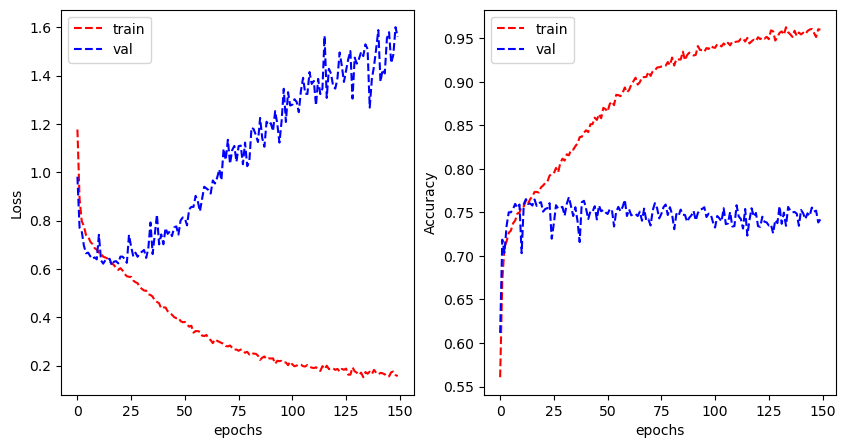

In [93]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ct_history_leNet.history['loss'], 'r--')
plt.plot(ct_history_leNet.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(ct_history_leNet.history['categorical_accuracy'], 'r--')
plt.plot(ct_history_leNet.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [94]:
evaluate_scores(ct_test, ct_model_leNet, "cellTypeName", "CNN Baseline Cell Type")

CNN Baseline Cell Type Model scores:
Found 2578 validated image filenames belonging to 4 classes.
Test loss: 1.7598453760147095
Test accuracy: 0.7366175055503845
81/81 [==============================] - 0s 4ms/step
F1-score: 0.3632576472646233
Precision: 0.3462871446721357
Recall: 0.386733902249806


### 7.3.4 Data Augmentation

In [95]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=ct_train,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=ct_val,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 4 classes.
Found 2577 validated image filenames belonging to 4 classes.


In [96]:
ct_model_leNet_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))])

In [97]:
ct_model_leNet_aug.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

ct_history_aug = ct_model_leNet_aug.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 3s 13ms/step - loss: 1.1945 - categorical_accuracy: 0.5500 - val_loss: 1.2478 - val_categorical_accuracy: 0.5712
Epoch 2/150
242/242 [==============================] - 3s 13ms/step - loss: 1.0545 - categorical_accuracy: 0.5810 - val_loss: 0.8719 - val_categorical_accuracy: 0.6558
Epoch 3/150
242/242 [==============================] - 3s 13ms/step - loss: 0.9157 - categorical_accuracy: 0.6583 - val_loss: 0.7733 - val_categorical_accuracy: 0.6962
Epoch 4/150
242/242 [==============================] - 3s 13ms/step - loss: 0.8412 - categorical_accuracy: 0.6938 - val_loss: 0.7333 - val_categorical_accuracy: 0.7334
Epoch 5/150
242/242 [==============================] - 3s 13ms/step - loss: 0.8104 - categorical_accuracy: 0.7039 - val_loss: 0.7223 - val_categorical_accuracy: 0.7299
Epoch 6/150
242/242 [==============================] - 3s 13ms/step - loss: 0.8005 - categorical_accuracy: 0.7095 - val_loss: 0.7167 - val_categorical_accuracy:

242/242 [==============================] - 3s 14ms/step - loss: 0.6381 - categorical_accuracy: 0.7661 - val_loss: 0.6306 - val_categorical_accuracy: 0.7629
Epoch 98/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6248 - categorical_accuracy: 0.7686 - val_loss: 0.6133 - val_categorical_accuracy: 0.7672
Epoch 99/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6287 - categorical_accuracy: 0.7692 - val_loss: 0.5999 - val_categorical_accuracy: 0.7687
Epoch 100/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6286 - categorical_accuracy: 0.7691 - val_loss: 0.6550 - val_categorical_accuracy: 0.7575
Epoch 101/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6341 - categorical_accuracy: 0.7698 - val_loss: 0.6142 - val_categorical_accuracy: 0.7773
Epoch 102/150
242/242 [==============================] - 3s 13ms/step - loss: 0.6254 - categorical_accuracy: 0.7736 - val_loss: 0.6067 - val_categorical_accuracy: 0.7

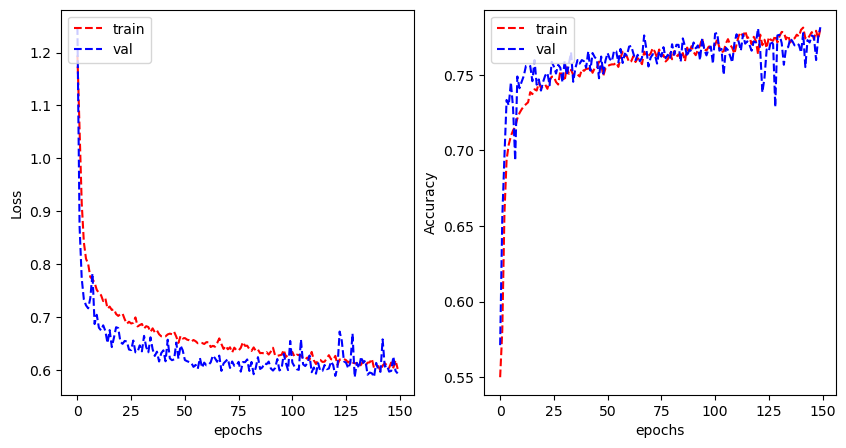

In [98]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ct_history_aug.history['loss'], 'r--')
plt.plot(ct_history_aug.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(ct_history_aug.history['categorical_accuracy'], 'r--')
plt.plot(ct_history_aug.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [99]:
evaluate_scores(ct_test, ct_model_leNet_aug, "cellTypeName", "Data Augmentated CNN Cell Type")

Data Augmentated CNN Cell Type Model scores:
Found 2578 validated image filenames belonging to 4 classes.
Test loss: 0.6166138648986816
Test accuracy: 0.7703646421432495
81/81 [==============================] - 0s 4ms/step
F1-score: 0.3431047605315805
Precision: 0.3396617724139893
Recall: 0.35065942591155935


## 7.4 Neural Networks (NN) Cell Type Model

### 7.4.1 Split Data into Train, Test & Validation Data

In [100]:
from sklearn.model_selection import train_test_split

ct_train, ct_test = train_test_split(cellType_data, test_size=0.2, random_state=0) 
ct_train, ct_val = train_test_split(ct_train, test_size=0.25, random_state=0)

print("Training Data:", ct_train.shape[0]) #60% of our X_ and y_
print("Testing Data:", ct_test.shape[0]) #20% of our X_ and y_
print("Validation Data:", ct_val.shape[0]) #20% of our X_ and y_

Training Data: 7731
Testing Data: 2578
Validation Data: 2577


### 7.4.2 Setting up layers

In [101]:
CT_INPUT_DIM = (27,27,3)
CT_HIDDEN_LAYER_DIM = 256
CT_OUTPUT_CLASSES = 4

### 7.4.3 Build Model

In [102]:
ct_nn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=CT_INPUT_DIM),
    tf.keras.layers.Dense(CT_HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(CT_OUTPUT_CLASSES)
])

In [103]:
ct_nn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2187)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               560128    
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


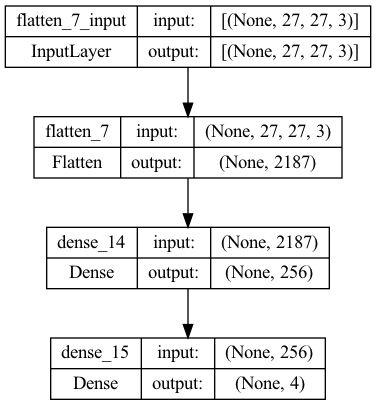

In [104]:
tf.keras.utils.plot_model(ct_nn_model, show_shapes=True)

### 7.4.4 Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [105]:
ct_nn_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### 7.4.5 Data loader

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=ct_train,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        dataframe=ct_val,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7731 validated image filenames belonging to 4 classes.
Found 2577 validated image filenames belonging to 4 classes.


### 7.4.7 Model Training

In [107]:
history = ct_nn_model.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 6ms/step - loss: 1.1156 - categorical_accuracy: 0.5532 - val_loss: 1.0563 - val_categorical_accuracy: 0.5534
Epoch 2/150
242/242 [==============================] - 1s 5ms/step - loss: 0.9956 - categorical_accuracy: 0.5880 - val_loss: 0.9519 - val_categorical_accuracy: 0.5941
Epoch 3/150
242/242 [==============================] - 1s 5ms/step - loss: 0.9104 - categorical_accuracy: 0.6314 - val_loss: 0.8712 - val_categorical_accuracy: 0.6511
Epoch 4/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8426 - categorical_accuracy: 0.6696 - val_loss: 0.8256 - val_categorical_accuracy: 0.6997
Epoch 5/150
242/242 [==============================] - 1s 5ms/step - loss: 0.7963 - categorical_accuracy: 0.6924 - val_loss: 0.7882 - val_categorical_accuracy: 0.6779
Epoch 6/150
242/242 [==============================] - 1s 5ms/step - loss: 0.7603 - categorical_accuracy: 0.7109 - val_loss: 0.7542 - val_categorical_accuracy: 0.703

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5921 - categorical_accuracy: 0.7749 - val_loss: 0.6202 - val_categorical_accuracy: 0.7637
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5921 - categorical_accuracy: 0.7753 - val_loss: 0.6467 - val_categorical_accuracy: 0.7536
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5901 - categorical_accuracy: 0.7788 - val_loss: 0.6247 - val_categorical_accuracy: 0.7645
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5904 - categorical_accuracy: 0.7766 - val_loss: 0.6519 - val_categorical_accuracy: 0.7423
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5899 - categorical_accuracy: 0.7734 - val_loss: 0.6487 - val_categorical_accuracy: 0.7443
Epoch 55/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5880 - categorical_accuracy: 0.7749 - val_loss: 0.6495 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5675 - categorical_accuracy: 0.7836 - val_loss: 0.6186 - val_categorical_accuracy: 0.7676
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5655 - categorical_accuracy: 0.7822 - val_loss: 0.6233 - val_categorical_accuracy: 0.7637
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5703 - categorical_accuracy: 0.7845 - val_loss: 0.6116 - val_categorical_accuracy: 0.7617
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5654 - categorical_accuracy: 0.7863 - val_loss: 0.6178 - val_categorical_accuracy: 0.7641
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5638 - categorical_accuracy: 0.7861 - val_loss: 0.6128 - val_categorical_accuracy: 0.7645
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5658 - categorical_accuracy: 0.7849 - val_loss: 0.6156 - val_categorical_accu

### 7.4.8 Save Model

In [108]:
ct_nn_model.save("ct_nn_model")

INFO:tensorflow:Assets written to: ct_nn_model/assets


INFO:tensorflow:Assets written to: ct_nn_model/assets


### 7.4.9 Load Model

In [109]:
ct_base_model = tf.keras.models.load_model('ct_nn_model')

### 7.4.10 Observations

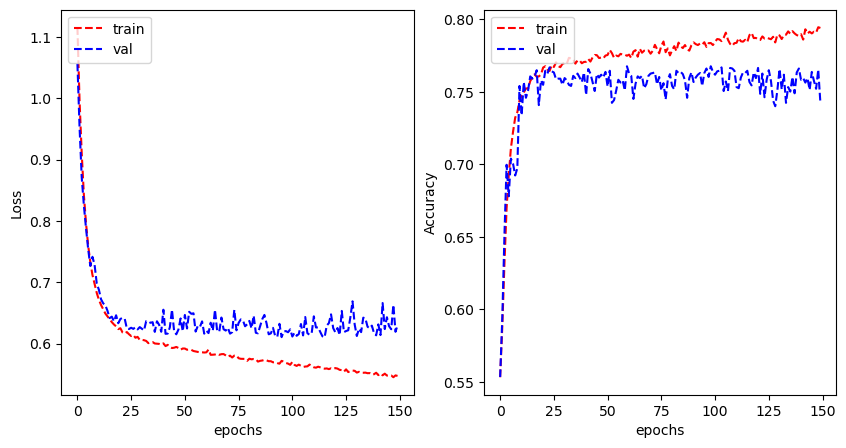

In [110]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on Cell Type NN Model:**
* Loss function outputted an overlap between train and validation set at approximately 0.35 (a lower value suggests that the model's predictions are quite good) and gets inceasingly better with every increase of epoch(s).
* Overfitting occurred as the training accuracy indicates that the model makes increasingly better predictions as the number of epochs rises. Whereas, the validation accuracy indicates that the model is more likely to make more errors in its predictions on the validation set compared to the training set, which could mean that the model was overfitted to the training set.

In [111]:
# calling evaluate_scores function made earlier in the code
evaluate_scores(ct_test, ct_base_model, "cellTypeName", "Baseline NN Cell Type")

Baseline NN Cell Type Model scores:
Found 2578 validated image filenames belonging to 4 classes.
Test loss: 0.6428194642066956
Test accuracy: 0.7517455220222473
81/81 [==============================] - 0s 5ms/step
F1-score: 0.35464735337909503
Precision: 0.35075913017792826
Recall: 0.36152055857253684


### Creating table to show all baseline models' accuracies for Cell Type classification
Table created with 5 columns; 'Baseline Model', 'Accuracy Score', 'WA F1-Score', 'WA Precision', 'WA Recall' to show all model performance results for Cell Type classification.

In [112]:
# Weighted Average = WA

from tabulate import tabulate

info = [['K-Nearest Neigbors', 0.564, 0.484, 0.523, 0.564], ['Random Forest Classifier', 0.605, 0.523, 0.605, 0.605], ['Convolutional Neural Networks', 0.663, 0.371, 0.356, 0.395], ['Neural Networks', 0.673, 0.372, 0.358, 0.398]]
headers = ['Baseline Model', 'Accuracy Score', 'WA F1-Score', 'WA Precision', 'WA Recall']
table = tabulate(info, headers, tablefmt='orgtbl')
print(table)

| Baseline Model                |   Accuracy Score |   WA F1-Score |   WA Precision |   WA Recall |
|-------------------------------+------------------+---------------+----------------+-------------|
| K-Nearest Neigbors            |            0.564 |         0.484 |          0.523 |       0.564 |
| Random Forest Classifier      |            0.605 |         0.523 |          0.605 |       0.605 |
| Convolutional Neural Networks |            0.663 |         0.371 |          0.356 |       0.395 |
| Neural Networks               |            0.673 |         0.372 |          0.358 |       0.398 |


## 7.5 Regularisation

In [113]:
reg_lambda = 0.01

ct_model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=CT_INPUT_DIM),
    tf.keras.layers.Dense(CT_HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(CT_OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [114]:
ct_model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [115]:
# train regularised model
history_reg = ct_model_reg.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 7ms/step - loss: 5.5766 - categorical_accuracy: 0.5528 - val_loss: 5.3234 - val_categorical_accuracy: 0.6030
Epoch 2/150
242/242 [==============================] - 2s 7ms/step - loss: 5.0684 - categorical_accuracy: 0.5801 - val_loss: 4.8405 - val_categorical_accuracy: 0.5770
Epoch 3/150
242/242 [==============================] - 2s 6ms/step - loss: 4.6368 - categorical_accuracy: 0.6161 - val_loss: 4.4461 - val_categorical_accuracy: 0.6597
Epoch 4/150
242/242 [==============================] - 2s 6ms/step - loss: 4.2532 - categorical_accuracy: 0.6431 - val_loss: 4.0784 - val_categorical_accuracy: 0.6562
Epoch 5/150
242/242 [==============================] - 1s 6ms/step - loss: 3.9153 - categorical_accuracy: 0.6643 - val_loss: 3.7680 - val_categorical_accuracy: 0.6674
Epoch 6/150
242/242 [==============================] - 1s 6ms/step - loss: 3.6175 - categorical_accuracy: 0.6766 - val_loss: 3.5115 - val_categorical_accuracy: 0.715

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8874 - categorical_accuracy: 0.7422 - val_loss: 0.8980 - val_categorical_accuracy: 0.7284
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8851 - categorical_accuracy: 0.7403 - val_loss: 0.8960 - val_categorical_accuracy: 0.7563
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8813 - categorical_accuracy: 0.7434 - val_loss: 0.8816 - val_categorical_accuracy: 0.7501
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8773 - categorical_accuracy: 0.7435 - val_loss: 0.8810 - val_categorical_accuracy: 0.7466
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8736 - categorical_accuracy: 0.7436 - val_loss: 0.8909 - val_categorical_accuracy: 0.7482
Epoch 55/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8708 - categorical_accuracy: 0.7419 - val_loss: 0.8739 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8483 - categorical_accuracy: 0.7440 - val_loss: 0.8613 - val_categorical_accuracy: 0.7532
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8476 - categorical_accuracy: 0.7458 - val_loss: 0.8508 - val_categorical_accuracy: 0.7447
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8467 - categorical_accuracy: 0.7432 - val_loss: 0.8562 - val_categorical_accuracy: 0.7582
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8489 - categorical_accuracy: 0.7432 - val_loss: 0.8516 - val_categorical_accuracy: 0.7435
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8488 - categorical_accuracy: 0.7417 - val_loss: 0.8915 - val_categorical_accuracy: 0.7059
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8492 - categorical_accuracy: 0.7401 - val_loss: 0.8521 - val_categorical_accu

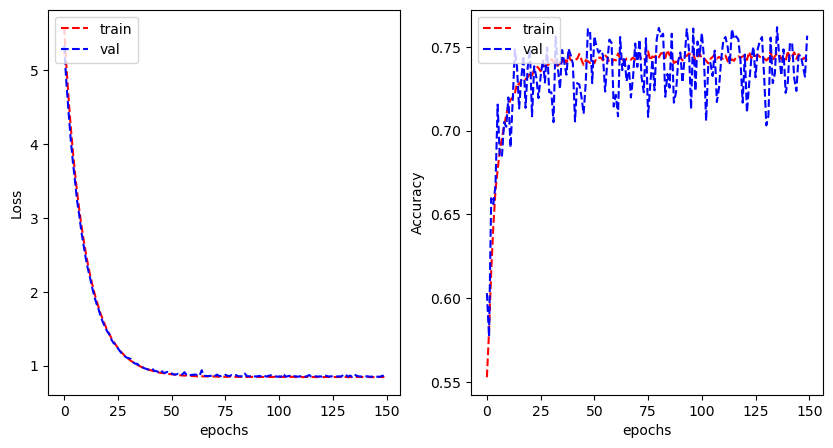

In [116]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on Regularised CNN Model:**
* The loss function shows the Train and Validation data very closely tied after Regularisation
* The accuracy function shows us that overfitting has been drastically reduced from the base model with the validation data

In [117]:
evaluate_scores(ct_test, ct_model_reg, "cellTypeName", "Regularised NN Cell Type")

Regularised NN Cell Type Model scores:
Found 2578 validated image filenames belonging to 4 classes.
Test loss: 0.8699369430541992
Test accuracy: 0.754072904586792
81/81 [==============================] - 0s 4ms/step
F1-score: 0.3676744543064147
Precision: 0.3507501331309932
Recall: 0.3875096974398759


/Users/eivy/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 7.6 Dropout

In [118]:
reg_lambda = 0.01

ct_model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=CT_INPUT_DIM),
    tf.keras.layers.Dense(CT_HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(CT_OUTPUT_CLASSES)
])

In [119]:
ct_model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [120]:
history_drop = ct_model_drop.fit(train_generator, validation_data = val_generator, epochs=150, verbose=1)

Epoch 1/150
242/242 [==============================] - 2s 6ms/step - loss: 1.1713 - categorical_accuracy: 0.5411 - val_loss: 1.0581 - val_categorical_accuracy: 0.5576
Epoch 2/150
242/242 [==============================] - 1s 5ms/step - loss: 1.0567 - categorical_accuracy: 0.5760 - val_loss: 0.9769 - val_categorical_accuracy: 0.5918
Epoch 3/150
242/242 [==============================] - 1s 5ms/step - loss: 0.9798 - categorical_accuracy: 0.6113 - val_loss: 0.9101 - val_categorical_accuracy: 0.6259
Epoch 4/150
242/242 [==============================] - 1s 5ms/step - loss: 0.9159 - categorical_accuracy: 0.6383 - val_loss: 0.8682 - val_categorical_accuracy: 0.6185
Epoch 5/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8765 - categorical_accuracy: 0.6555 - val_loss: 0.8285 - val_categorical_accuracy: 0.6682
Epoch 6/150
242/242 [==============================] - 1s 5ms/step - loss: 0.8333 - categorical_accuracy: 0.6731 - val_loss: 0.7902 - val_categorical_accuracy: 0.670

Epoch 50/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6292 - categorical_accuracy: 0.7590 - val_loss: 0.6381 - val_categorical_accuracy: 0.7555
Epoch 51/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6324 - categorical_accuracy: 0.7616 - val_loss: 0.6246 - val_categorical_accuracy: 0.7664
Epoch 52/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6264 - categorical_accuracy: 0.7668 - val_loss: 0.6254 - val_categorical_accuracy: 0.7610
Epoch 53/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6274 - categorical_accuracy: 0.7638 - val_loss: 0.6217 - val_categorical_accuracy: 0.7645
Epoch 54/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6259 - categorical_accuracy: 0.7590 - val_loss: 0.6276 - val_categorical_accuracy: 0.7629
Epoch 55/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6242 - categorical_accuracy: 0.7615 - val_loss: 0.6221 - val_categorical_accuracy:

Epoch 99/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6029 - categorical_accuracy: 0.7682 - val_loss: 0.6115 - val_categorical_accuracy: 0.7633
Epoch 100/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6051 - categorical_accuracy: 0.7690 - val_loss: 0.6287 - val_categorical_accuracy: 0.7645
Epoch 101/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6074 - categorical_accuracy: 0.7642 - val_loss: 0.6164 - val_categorical_accuracy: 0.7575
Epoch 102/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5997 - categorical_accuracy: 0.7721 - val_loss: 0.6206 - val_categorical_accuracy: 0.7575
Epoch 103/150
242/242 [==============================] - 1s 5ms/step - loss: 0.5969 - categorical_accuracy: 0.7690 - val_loss: 0.6112 - val_categorical_accuracy: 0.7683
Epoch 104/150
242/242 [==============================] - 1s 5ms/step - loss: 0.6026 - categorical_accuracy: 0.7712 - val_loss: 0.6120 - val_categorical_accu

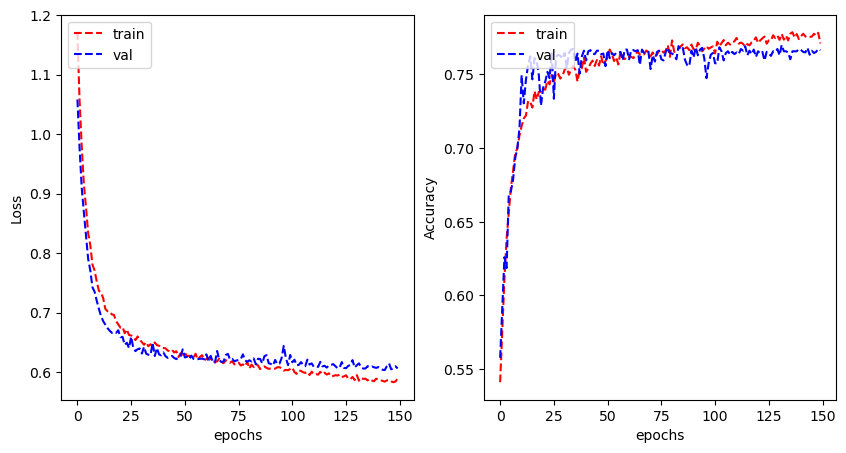

In [121]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**Observations/Evaluations on Base Model after Dropout (no regularisation):**
* The loss values are much consistgently lower in comparison to the Regularised model
* The validation data closely follows the train data in both Loss and Accuracy
* There is less fluctuation in the validation set accuracy

In [122]:
evaluate_scores(ct_test, ct_model_drop, "cellTypeName", "Dropout NN Cell Type")

Dropout NN Cell Type Model scores:
Found 2578 validated image filenames belonging to 4 classes.
Test loss: 0.6151754260063171
Test accuracy: 0.7622187733650208
81/81 [==============================] - 0s 4ms/step
F1-score: 0.3747160504135903
Precision: 0.3640793247176415
Recall: 0.39061287820015517


## 7.7 Ultimate Judgement
In this area of the notebook, we have built and trained between yet another four different types of supervised machine learning algorithms; KNN, Random Forest Classifier, CNN and NN to classify cells as either epithelial, inflammatory, fibroblast and others (miscellaneous) from images. 

The same criteria applied to concluding the "best" model in cancerous cell image classification was used here as well, from which the regularised (data augmentation) CNN model once again had the more superior model performance scores. Achieving a lower loss function, a higher accuracy score, and a similar f1-score when compared to that of the baseline model.

Thus, we recommend using CNN with Data Augmentation for the classification and prediction of Cell Type and below demonstrates how the model performed in predicting on unseen test data.

## 7.8 Predictions on Random Images

In [123]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=ct_test,
        directory='./',
        x_col="ImagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2578 validated image filenames belonging to 4 classes.


In [124]:
cell_strings = {'fibroblast':0, 'inflammatory':1, 'epithelial':2, 'others':3}

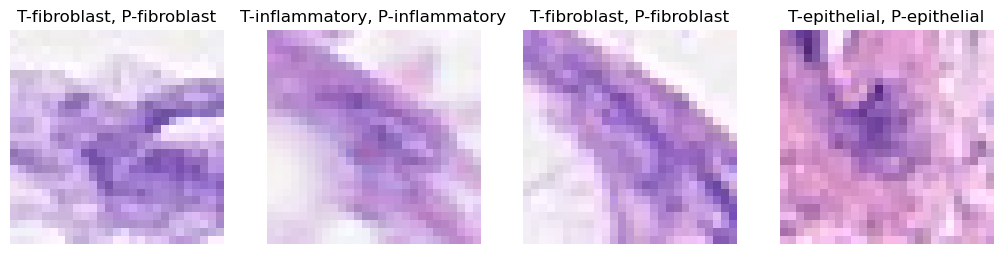

In [125]:
label_strings_inv = {v: k for k, v in cell_strings.items()}
#pred_string_val = [label_strings_inv[cell_strings[i]] for i in range(len(cell_strings))]
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_pred = ct_model_leNet_aug.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("T-{}, P-{}".format(label_strings_inv[np.argmax(y[0])], label_strings_inv[np.argmax(y_pred[0])] ))
            
        else:
            break
        
        plt.axis('off')